# **Defending the Edge: Quality of Block Index**
proposing a mathematical basis for analysing and rating quality of play of Offensive Tackles against the Edge. Additional analysis is conveyed in relating the quality of play in the NFL to results from the NFL Combine. 

QBI is one of three proposed measures to gauge OT play against the Edge. 1. QBI, 2. Blocking Cohesion, 3. Time on Block. An overall score is generated for each OT based on these three measures. Herein is presented the algorithm for calculating QBI, Blocking Cohesion and Time on Block. These are combined into the QBI Metric, and the Block Metric which takes Cohesion and Time to generate a score which is added to the QBI to give an overall score. 

QBI + BM = Score

Data was aggregated by the <a href="https://colab.research.google.com/drive/1nPgD7U6zJIHLGlonTdbDhq3ApHCcMFCM?usp=sharing">OT_Defending_The_Edge_Metric_Aggregation.ipynb</a> notebook file


to plot plays, use defending-the-edge-plots.ipynb


In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from functools import partial
from matplotlib.animation import writers
import os


#%matplotlib inline

In [2]:
# Import from GoogleDrive

from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("//content/gdrive/MyDrive/nfl-big-data-bowl-2023/")

data_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/"
save_dir = "/content/gdrive/My Drive/nfl-big-data-bowl-2023/charts/"
#if on kaggle
#data_dir = "/kaggle/input/nfl-big-data-bowl-2023/"

'''
data_dir = "../input/metrics-databowl-v2/original_databowl.db"
OUTPUT_DIR = './'
'''

Mounted at /content/gdrive


'\ndata_dir = "../input/metrics-databowl-v2/original_databowl.db"\nOUTPUT_DIR = \'./\'\n'

In [3]:
import sqlite3

# Create a SQL connection to a local SQLite database
con = sqlite3.connect(data_dir + "original_databowl.db")

# **Measuring Euclidean Distance**

the Euclidean distance between two points in Euclidean space is the length of a line segment between the two points.

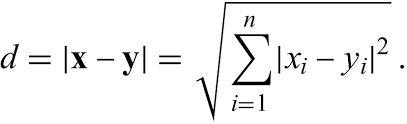



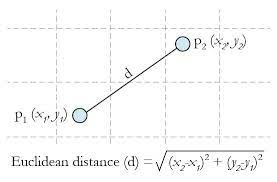

I use the euclidean distance between QB and OT, and for QB and DE as a metric for pressure on the Quarterback and for other metrics, for instance 'time on block' of OT on DE, measuring the (d) over a time series. Block Cohesion also ustilized Euclidean distance (d). 

In [4]:
def get_distance(p, q):
    """ 
    Return euclidean distance between points p and q
    assuming both to have the same number of dimensions
    p is a tuple of x,y coords ie Offensive Tackle (OT)
    q is a tuple of x,y coords ie Defensive End (DE)

    function called by metric_euclidean(offense_tracking, defender_tracking) see below
    """
    # sum of squared difference between coordinates
    s_sq_difference = 0
    for p_i,q_i in zip(p,q):
        s_sq_difference += (p_i - q_i)**2
    
    # take sq root of sum of squared difference
    distance = s_sq_difference**0.5
    return distance

# check the function
OT = (2, 3)
DE = (5, 7)
# distance b/w a and b
d = get_distance(OT, DE)
# display the result
print(d)

#https://docs.scipy.org/doc/scipy/reference/spatial.distance.html
from scipy.spatial import distance
res = distance.euclidean(OT, DE)
print(res)

5.0
5.0


**Basic Metrics Functions**

In [5]:
def combine_to_active_roster():
    #gets a list of OT in players table that match a row in combine table 
    sql = """
           select * from players as p, combine as c where p.officialPosition = 'T' and c.Name = p.displayName
    """
    #print(sql)  
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query

OT_in_league = combine_to_active_roster()
#print(OT_in_league)



def blocker_metrics(nfl_id):
    sql = """
           select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query

def plays_to_events(nfl_id, event):
    #nfl_id is the nflId of the blocker, here Offensive Tackle (OT)
    #event is the metric: pff_beatenByDefender, pff_hitAllowed, pff_hurryAllowed, pff_sackAllowed =1, 'none' is where all = 0
    event_plays = [] # a list for plays for given event
    
    if event == 'pff_beatenByDefender':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """
              AND pff.pff_beatenByDefender = 1  
        """  
        beatenByDefender_query = pd.read_sql_query(sql, con)
        for i,r in beatenByDefender_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)


    if event == 'pff_hitAllowed':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
              AND pff.pff_hitAllowed = 1 
        """  
        hitAllowed_query = pd.read_sql_query(sql, con)
        for i,r in hitAllowed_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)

    if event == 'pff_hurryAllowed':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
              AND pff.pff_hurryAllowed = 1 
        """  
        hurryAllowed_query = pd.read_sql_query(sql, con)
        for i,r in hurryAllowed_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)

    if event == 'pff_sackAllowed':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
              AND pff.pff_sackAllowed = 1 
        """  
        #print(sql)
        sackAllowed_query = pd.read_sql_query(sql, con)
        for i,r in sackAllowed_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)
        
    if event == 'none':
        sql = """
              select * from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
              AND pff.pff_hitAllowed = 0 
              AND pff.pff_hurryAllowed = 0 
              AND pff.pff_sackAllowed = 0 
              AND pff.pff_beatenByDefender = 0 
        """  
        none_query = pd.read_sql_query(sql, con)
        for i,r in none_query.iterrows():
          game_plays = str(r['gameId']) + "," + str(r['playId']) + "," + str(r['pff_nflIdBlockedPlayer'])
          event_plays.append(game_plays)

    return event_plays




def listToString(s):
   
    # initialize an empty string
    str1 = " "
   
    # return string 
    return (str1.join(s))


def player_tracking_clipped(nfl_id, game_id, play_id):

    sql = """
           select * from weeks as wk WHERE wk.nflId = """ + str(nfl_id) + """ 
           AND  wk.gameId = """ + str(game_id) + """ 
           AND  wk.playId = """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    #print(sql)
    #print(query)
    return query


def combine_results(nfl_id):
    name_sql = """
           select p.displayName from players as p WHERE p.nflId = """ + str(nfl_id) + """ 
            
    """  
    name = pd.read_sql_query(name_sql, con)
    name = name.values.tolist()
    for n in name:
      player_name = n
      player_name = listToString(player_name)
      player_name = player_name.replace("'", " " )

    sql = """
           select * from combine as c WHERE c.Name = '""" + str(player_name) + """' 
            
    """  
    query = pd.read_sql_query(sql, con)
    #print(sql)
    #print(query)
    return query

def player_role(nfl_id):

    sql = """
           select pff_positionLinedUp from pffScoutingData as pff WHERE pff.nflId = """ + str(nfl_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    #print(sql)
    #print(query)
    return query

def metric_euclidean(offense_tracking, defender_tracking):
    #reference 1 variables, usually offensive player    
    x_y_coords = offense_tracking[['x', 'y']]
    records = x_y_coords.to_records(index=False)
    result = list(records)
    x_y_coords_list = result
    reference1_id = offense_tracking.iloc[0]['nflId']
    game_id = offense_tracking.iloc[0]['gameId']
    play_id = offense_tracking.iloc[0]['playId']
    ref1_role = player_role(reference1_id) #make a lookup of pff_position
    ref1_role = ref1_role.iloc[0]['pff_positionLinedUp']
    ref1_acceleration = offense_tracking['a'].max() 
    ref1_yards = offense_tracking['dis'].sum()
    ref1_avg_speed = offense_tracking['s'].mean() #avg(s), alter table ref1 speed, ref2 seed
    play_length = len(offense_tracking) * .1 #sum of frames



    #reference 2 variables, usually defender
    x_y_coords_defender = defender_tracking[['x', 'y']]
    defender_records = x_y_coords_defender.to_records(index=False)
    defender_result = list(defender_records)
    defender_x_y_coords_list = defender_result
    reference2_id = defender_tracking.iloc[0]['nflId']
    ref2_role = player_role(reference2_id) #make a lookup of pff_position
    ref2_role = ref2_role.iloc[0]['pff_positionLinedUp']
    ref2_acceleration = defender_tracking['a'].max() 
    ref2_yards = defender_tracking['dis'].sum() #sum(dis), alter table ref1 yards, ref2 yards
    ref2_avg_speed = defender_tracking['s'].mean() #avg(s), alter table ref1 speed, ref2 seed



    for c,k in enumerate(defender_x_y_coords_list):
      reference1_x = x_y_coords_list[c][0]
      reference1_y = x_y_coords_list[c][1]
      ref1_tuple = x_y_coords_list[c]
      reference2_x = defender_x_y_coords_list[c][0]
      reference2_y = defender_x_y_coords_list[c][1]
      ref2_tuple = defender_x_y_coords_list[c]
      euclidian_distance = get_distance(ref1_tuple, ref2_tuple)
    
      # Create a new record
      cursor = con.cursor()
      sql = "INSERT INTO `frame_metrics` (`reference1_id`, `reference2_Id`, `reference1_x`, `reference1_y`, `gameId`, `playId`, `ref1_role`, `ref2_role`, `reference2_x`, `reference2_y`, `euclidean`, `ref1_acceleration`, `ref2_acceleration`, `ref1_yards`, `ref2_yards`, `ref1_avg_speed`, `ref2_avg_speed`, `play_length`) VALUES (" + str(reference1_id) + ", " + str(reference2_id) + ", " + str(reference1_x) +", " + str(reference1_y) + ", " + str(game_id) + ", " + str(play_id) + ", '" + ref1_role + "', '" + ref2_role + "', " + str(reference2_x) + ", " + str(reference2_y) + ", " + str(euclidian_distance) + ", " + str(ref1_acceleration) + "," + str(ref2_acceleration) + ", " + str(ref1_yards) + "," + str(ref2_yards) + ", " + str(ref1_avg_speed) + ", " + str(ref2_avg_speed) + "," + str(play_length) + ")"         
      print(sql)
      # Execute the query
      cursor.execute(sql)
      # the connection is not autocommited by default. So we must commit to save our changes.
      con.commit()
                
def convert_yds_to_mph(seconds, distance):    
    d_ft = distance * 3
    d_inches = d_ft * 12
    d_yards = d_ft / 3.0
    d_miles = d_ft / 5280.0
    miles = print("Input distance in miles ", d_miles)

    hours=float(seconds)/3600
    mph = float(d_miles)/seconds*3600
    return(mph)

def get_clipped_nflids_OT(): 
    sql = """
           select DISTINCT(wk.nflId) from pffScoutingData as pff, weeks as wk where pff.pff_positionLinedUp IN ('LT', 'RT') 
AND pff.nflId = wk.nflId  
    """ 
    query = pd.read_sql_query(sql, con)
    #print(query)
    return query




################## END Function Definitions ####################################



# **Basic Metrics from PffScoutingData**


4 Base Metrics: beatenByDefender, hitAllowed, hurryAllowed, sackAllowed

In [ ]:
#how much weight to put on each of the different metric events, sack is more damaging then hurry, etc. 
clipped_nflids = get_clipped_nflids_OT()

nfl_ids = clipped_nflids[['nflId']]
print(nfl_ids)

for c,r in nfl_ids.iterrows():
  player_id = r['nflId']
  player_metric = blocker_metrics(player_id)
  if(len(player_metric) >= 1):
    #get total (sum) of 4 metrics tracked by pff for OL in pffScoutingData table
    beaten_by_defender = player_metric['pff_beatenByDefender'].sum()
    hit_allowed = player_metric['pff_hitAllowed'].sum()
    hurry_allowed = player_metric['pff_hurryAllowed'].sum()
    sack_allowed = player_metric['pff_sackAllowed'].sum()
    #get [gameId, playId, pff_nflIdBlockedPlayer] returned in a list for each metric event
    beaten_plays = plays_to_events(player_id, 'pff_beatenByDefender')
    hit_plays = plays_to_events(player_id, 'pff_hitAllowed')
    hurry_plays = plays_to_events(player_id, 'pff_hurryAllowed')
    sack_plays = plays_to_events(player_id, 'pff_sackAllowed')
    combine_performance = combine_results(player_id)
    #display metrics for each player
    print()
    print("-------------------------------------------------------")
    print(c)
    print("Player Metrics: ", r['nflId'])
    print("Combine Performance: ", combine_performance)
    print()
    print("Total Plays: ", len(player_metric))
    print("Fouls Committed: ")
    print("beaten by defender: ", beaten_by_defender, beaten_plays)
    print("hit allowed: ", hit_allowed, hit_plays)
    print("hurry allowed: ", hurry_allowed, hurry_plays)
    print("sack allowed: ", sack_allowed, sack_plays)

    print()


#TODO: add accounting for penalties, penalty yards, etc. is there a model for holding

KeyboardInterrupt: ignored

# **Modeling of Edge Blocking**



# **frame_metrics table:**
has two references divided up into 3 aspects: ot-to-de, qb-to-ot, qb-to-de

**ot-to-de** is used to measure quality of block index which is to say the amount of control over the Defensive End by the Offensive Tackle

**qb-to-ot** is used to measure how far the OT remains from the QB

**qb-to-de** is used to measure how far the DE remains from the QB and whether he enters the safe zone around the quarter back 1.5 yds, then there is the reach zone which is <1.0 yds around the QB, and of course the death zone which is <.7 yds from the QB. 

All measured by Euclidean distance. 

# **QBI Rating for Each Play**

In [170]:
def game_frames(reference1_id, reference2_id, game_id, play_id):

    sql = """
           select * from frame_metrics as fm WHERE fm.reference1_id = """ + str(reference1_id) + """ 
           AND  fm.reference2_id = """ + str(reference2_id) + """ 
           AND  fm.gameId = """ + str(game_id) + """ 
           AND  fm.playId = """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query

def ids_for_frames(game_id, play_id):

    sql = """
           select DISTINCT reference1_id, reference2_id, ref1_role, ref2_role from frame_metrics as fm WHERE fm.gameId = """ + str(game_id) + """ 
           AND  fm.playId = """ + str(play_id) + """ 
    """  
    query = pd.read_sql_query(sql, con)
    return query




def add_data_to_metrics(blocker_id, defender_id, game_id, play_id, buffer, dangerarea, sackarea, def_buffer, def_dangerarea, def_sackarea, beaten, regained, rating):
    #print(write_buffer)

    cursor = con.cursor()
    sql = "INSERT INTO `qbi_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `qbi_rating`, `beaten`, `regained`, `block_buffer`, `block_dangerarea`, `block_sackarea`, `rush_buffer`, `rush_dangerarea`, `rush_sackarea` ) VALUES (" + str(blocker_id) + "," + str(defender_id) + "," + str(game_id) + "," + str(play_id) + "," + str(rating) + ", " + str(beaten) + ","  + str(regained) + ", " + str(buffer) + ", " + str(dangerarea) + "," + str(sackarea) + "," + str(def_buffer) + "," + str(def_dangerarea) + "," + str(def_sackarea) + ")"
    #print(sql)   
    # Execute the query
    cursor.execute(sql)
    # the connection is not autocommited by default. So we must commit to save our changes.
    con.commit()
    


def rate_play(play_dataframe, blocker_id, defender_id, game_id, play_id):
    penalty = False
    rating = 3
    play_length_unclipped = len(play_dataframe)
    pos = 0
    beaten = False
    regained = False
    penalty_value = 0
    buffer_penalty = False
    def_buffer_penalty = False
    buffer_penalty_value = 0
    def_buffer_penalty_value = 0
    dangerarea_penalty = False
    def_dangerarea_penalty = False
    dangerarea_penalty_value = 0
    def_dangerarea_penalty_value = 0
    sackarea_penalty = False
    def_sackarea_penalty = False
    sackarea_penalty_value = 0
    def_sackarea_penalty_value = 0
    play_dataframe = play_dataframe[5:play_length_unclipped-5]
    play_length = len(play_dataframe)
    
    
    if play_length >= 35:
        play_length = 35 #maximum play length is 3.5 sec, 35 frames
    else:
        play_length = play_length
    
    #print("play length original/clipped: ", play_length_unclipped, play_length)
    for c,i in play_dataframe.iterrows():
        if c > 39:
            break
            
        block_distance = i['block_euclidean']
        qb_blocker_distance = i['qb_blocker_euclidean']
        qb_rusher_distance = i['qb_rusher_euclidean']
        
        #print("row: ", c, qb_blocker_distance, qb_rusher_distance)
        
        rusher_min = qb_rusher_distance
        blocker_min = qb_blocker_distance
        
         
        #  beat by a difference of .01 in euclidean distance is around .33 inches
        #  beat by a difference of .1 in euclidean distance is around 3.6 incehs
        if(qb_rusher_distance < qb_blocker_distance):
            beaten = True
            regained = False
            pos = c
            #print("beaten")
        
        if(qb_rusher_distance > qb_blocker_distance and beaten == True):
            regained = True
            #print("regained control")
         
            
        if rusher_min < 1.5:
            #print("def in buffer zone, subtracting points")
            if def_buffer_penalty == False:
                def_buffer_penalty_value = def_buffer_penalty_value + .5
            def_buffer_penalty = True
            
        if rusher_min < 1.0:
            #print("def in danger area, subtracint points")
            if def_dangerarea_penalty == False:
                def_dangerarea_penalty_value = def_dangerarea_penalty_value + .5
            def_dangerarea_penalty = True
            
        if rusher_min < .7:
            #print("def in sack zone, block zeroed out")
            if def_sackarea_penalty == False:
                def_sackarea_penalty_value = def_sackarea_penalty_value + 3
            def_sackarea_penalty = True
            
    
        if blocker_min < 1.5:
            #print("blocker in buffer zone")
            if buffer_penalty == False:
                buffer_penalty_value = buffer_penalty_value + .5
            buffer_penalty = True
            
        if blocker_min < 1.0:
            #print("blocker in dangerarea")
            if dangerarea_penalty == False:
                dangerarea_penalty_value = dangerarea_penalty_value + .5
            dangerarea_penalty = True
            
    
        if blocker_min < .7:
            #print("blocker in sack/reach zone")
            if sackarea_penalty == False:
                sackarea_penalty_value = sackarea_penalty_value + 3
            sackarea_penalty = True
            
        
        
    if(beaten == True and regained == True):        
        #print("heuristic penalty triggered")
        penalty = True
        penalty_value = .25
    
    if(beaten == True and regained == False):
        penalty = True
        penalty_value = .50
        
    
    #rating = rating - penalty_value
    rating = rating - penalty_value - buffer_penalty_value - dangerarea_penalty_value - sackarea_penalty_value - def_buffer_penalty_value - def_dangerarea_penalty_value - def_sackarea_penalty_value
    
    if rating < 0:
        rating = 0
    
    #add_data_to_metrics() stuff here    
    if buffer_penalty == True:
        write_buffer = 1
    else:
        write_buffer = 0
    
    if dangerarea_penalty == True:
        write_dangerarea = 1
    else:
        write_dangerarea = 0
    
    if sackarea_penalty == True:
        write_sackarea = 1
    else: 
        write_sackarea = 0
    
    if def_buffer_penalty == True:
        def_write_buffer = 1
    else:
        def_write_buffer = 0
    
    if def_dangerarea_penalty == True:
        def_write_dangerarea = 1
    else:
        def_write_dangerarea = 0
    
    if def_sackarea_penalty == True:
        def_write_sackarea = 1
    else: 
        def_write_sackarea = 0
    
    if beaten == True:
        write_beaten = 1
    else:
        write_beaten = 0
    
    if regained == True:
        write_regained = 1
    else: 
        write_regained = 0
    
    add_data_to_metrics(blocker_id, defender_id, game_id, play_id, write_buffer, write_dangerarea, write_sackarea, def_write_buffer, def_write_dangerarea, def_write_sackarea, write_beaten, write_regained, rating)
    
    
    return rating



def plays_for_player(nfl_id):

    sql = """
           select DISTINCT gameId, playId from frame_metrics as fm WHERE fm.reference1_id = """ + str(nfl_id) + """ 
    
    """  
    query = pd.read_sql_query(sql, con)
    return query

def passer_for_play(nfl_id, game_id, play_id):

    sql = """
           select DISTINCT reference1_id from frame_metrics as fm WHERE fm.reference2_id = """ + str(nfl_id) + """ 
           AND fm.playId = """ + str(play_id) + """  
           AND fm.gameId = """ + str(game_id) + """
    """  
    query = pd.read_sql_query(sql, con)
    return query

def defender_for_play(nfl_id, game_id, play_id):

    sql = """
           select DISTINCT reference2_id from frame_metrics as fm WHERE fm.reference1_id = """ + str(nfl_id) + """ 
           AND fm.playId = """ + str(play_id) + """  
           AND fm.gameId = """ + str(game_id) + """
    """  
    query = pd.read_sql_query(sql, con)
    return query

def add_data_to_block_metrics(blocker_id, defender_id, game_id, play_id, arm_score, arm_cnt, control_score, control_cnt, interface_score, interface_cnt, total_frames, euclideans, efficiency, momentum_rating, distances_list):
    cursor = con.cursor()
    sql = "INSERT INTO `block_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `arm_score`, `arm_cnt`, `control_score`, `control_cnt`, `interface_score`, `interface_cnt`, `total_frames`, `euclideans`, `efficiency`, `momentum_rating`, `distances_list` ) VALUES (" + str(blocker_id) + "," + str(defender_id) + "," + str(game_id) + "," + str(play_id) + "," + str(arm_score) + ", " + str(arm_cnt) + ","  + str(control_score) + ", " + str(control_cnt) + ", " + str(interface_score) + "," + str(interface_cnt) + "," + str(total_frames) + ",'" + str(euclideans) + "', " + str(efficiency) + ", " + str(momentum_rating) + ", '" + str(distances_list) + "')"
    print(sql)   
    # Execute the query
    cursor.execute(sql)
    # the connection is not autocommited by default. So we must commit to save our changes.
    con.commit()
  


# **QBI Aggregation and Write to SQLite DB Metric Table**

In [171]:


#get list of gameId, playIds for OT player, i.e. 42377
nfl_id = 42377
tackle_plays = plays_for_player(nfl_id)
df_length = len(tackle_plays) - 1
for c,t in tackle_plays.iterrows():
    #print(c)
    if c > df_length:
        break
    
    game_id = t['gameId']
    play_id = t['playId']
    #get passer id
    passer_id = passer_for_play(nfl_id, game_id, play_id)
    passer_id = passer_id['reference1_id'][0]
    #get defender id
    defender_id = defender_for_play(nfl_id, game_id, play_id)
    defender_id = defender_id['reference2_id'][0]
    #get euclidean dataframes
    player_tracking_for_play = game_frames(nfl_id, defender_id, game_id, play_id)
    qb_tracking_offense = game_frames(passer_id, nfl_id, game_id, play_id)
    qb_tracking_defense = game_frames(passer_id, defender_id, game_id, play_id)

    df_len = len(player_tracking_for_play)
    df_limit = df_len - 5

    block_metrics = player_tracking_for_play[['ref1_role', 'ref2_role', 'euclidean']]
    qb_metrics_offense = qb_tracking_offense[['ref1_role', 'ref2_role', 'euclidean']]
    qb_metrics_defense = qb_tracking_defense[['ref1_role', 'ref2_role', 'euclidean']]
    block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
    qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'ref2_role':'QB_Blocker', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
    qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'ref2_role':'QB_Rusher', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

    metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
    rating_data = metrics_concat[['block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]

    play = rating_data
    play_rating = rate_play(play, nfl_id, defender_id, game_id, play_id)
    

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [172]:

sql = "select * from qbi_metrics"

#sql = "SELECT name FROM sqlite_schema WHERE type IN ('table','view') AND name NOT LIKE 'sqlite_%'ORDER BY 1"
query = pd.read_sql_query(sql, con)
print(len(query))
#display(query)
with pd.option_context('display.max_rows', None,):
    display(query)

293


,blocker_id,defender_id,gameId,playId,qbi_rating,beaten,regained,block_buffer,block_dangerarea,block_sackarea,rush_buffer,rush_dangerarea,rush_sackarea
0,42377,42403,2021090900,97,3.00,0,0,0,0,0,0,0,0
1,42377,53441,2021090900,410,3.00,0,0,0,0,0,0,0,0
2,42377,42403,2021090900,434,3.00,0,0,0,0,0,0,0,0
3,42377,42403,2021090900,456,3.00,0,0,0,0,0,0,0,0
4,42377,46185,2021090900,480,2.50,0,0,1,0,0,0,0,0
5,42377,46185,2021090900,509,2.75,1,1,0,0,0,0,0,0
6,42377,42403,2021090900,559,3.00,0,0,0,0,0,0,0,0
7,42377,42403,2021090900,583,3.00,0,0,0,0,0,0,0,0
8,42377,53441,2021090900,869,3.00,0,0,0,0,0,0,0,0
9,42377,46185,2021090900,925,0.00,1,1,1,1,1,1,1,1


# **Measuring Cohesion in Blocking**

2 measures: Blocking Cohesion and Time on Block

Cohesion measures the closeness of blocker to defender a rough measure of the degree of interface between the two.

Time on Block measures the length of the block, how long the blocker is able to engage the defender to deter them from the Quarterback

In these measures anything < 1.6667, which is the combined reach of two players with a height around 6'6" standing face to face, the general starting limit of any possible physical contact

In [174]:
#cohesion and time metrics
def distance_for_interface(nfl_id, game_id, play_id, start, end):
    
    sql = """
           SELECT frameId,dis from weeks where gameId = """ + str(game_id) + """ AND playId = """ + str(play_id) + """ AND nflId = """ + str(nfl_id) + """  
           LIMIT """+str(start)+""","""+str(end)+""" 
    """ 

    #print(sql) 
    query = pd.read_sql_query(sql, con)
    return query 

def rate_distances(distances, euclideans):
    distances_list = []
    rating = 0
    distance_end = len(distances) -1
    distance_val = distances['dis'][0]
    distance_val_end = distances['dis'][distance_end]
    slowed = []
    increased = []
    #add up frames where momentum slowed to momentum increased
    #divide slowed by total interface frames = score
    
    print(distance_val, distance_val_end)

    for c,i in distances.iterrows():
      print(c,i['dis'])
      distances_list.append(i['dis'])
      if c > 0:
        prev_dis = distances['dis'][c-1]
        current_dis = i['dis']
      
    
      if c > 0 and prev_dis >= current_dis:
        slowed.append(current_dis)
      else:
        increased.append(i['dis'])

    print(len(increased))
    print(len(slowed))
    print(len(distances))

    rating = len(slowed) / len(distances)
    
    
    return rating, distances_list



#get list of gameId, playIds for OT player, i.e. 42377
nfl_id = 42377
tackle_plays = plays_for_player(nfl_id)
df_length = len(tackle_plays) - 1
for c,t in tackle_plays.iterrows():
    if c > 0:
        break
    
    game_id = t['gameId']
    play_id = t['playId']
    #get defender id
    defender_id = defender_for_play(nfl_id, game_id, play_id)
    defender_id = defender_id['reference2_id'][0]
    player_tracking_for_play = game_frames(nfl_id, defender_id, game_id, play_id)
    df_len = len(player_tracking_for_play)
    df_limit = df_len - 5
    if df_len > 40:
      df_len = 40
    

    block_metrics = player_tracking_for_play[['ref1_role', 'ref2_role', 'euclidean']]
    block_metrics.rename(columns = {'ref1_role':'Blocker', 'ref2_role':'Rusher', 'euclidean':'block_euclidean'}, inplace = True)
    block_metrics = block_metrics[5:df_len-5]

    interface_zone = block_metrics.loc[block_metrics['block_euclidean'] < 1.6667]
    
    interface_zone_cnt = len(interface_zone)
    if interface_zone_cnt > 0:

        interface_zone_index = interface_zone['block_euclidean'].index
        interface_start = interface_zone_index[0]
        interface_end = len(interface_zone)

        control_block = block_metrics.loc[block_metrics['block_euclidean'] < .8]
        
        distances = distance_for_interface(nfl_id, game_id, play_id, interface_start-1, interface_end)
        
        eucls = interface_zone['block_euclidean']

        momentum_rating, distances_list = rate_distances(distances, interface_zone)
        distances_list = str(distances_list)
        
        print(momentum_rating, distances_list)

        control_cnt = len(control_block)
        eucl_avg = interface_zone['block_euclidean'].mean()
        interface_cnt = len(interface_zone)
        control_ratio = control_cnt / interface_cnt
        interface_ratio = interface_cnt / len(block_metrics)
        arm_block_cnt = interface_cnt - control_cnt
        arm_block_ratio = arm_block_cnt / interface_cnt
        regularization_factor = 35 / interface_cnt
        arm_score = arm_block_cnt * .8
        control_score = control_cnt * 1
        final_score = arm_score + control_score 
        #final_score = final_score * regularization_factor
        final_score = arm_score + control_score #out of 28 + 35, 63 total possible points
        interface_score = final_score
        total_frames = df_len - 10
        if df_len > 35:
          total_frames = 35
        euclideans = eucls.to_string(index = True)  
        block_efficiency = final_score / interface_cnt
    else:
      continue

    add_data_to_block_metrics(nfl_id, defender_id, game_id, play_id, arm_score, arm_block_cnt, control_score, control_cnt, interface_score, interface_cnt, total_frames, euclideans, block_efficiency, momentum_rating, distances_list)
    blocks = interface_zone
    #print()

#  add momentum measure of interface frames, need the 'dis' column, is dis > or < affects overall score
#  SELECT * from week1 where gameId = 2021090900 AND playId = 97 AND nflId = 42403 LIMIT 5, 33 #limit is start of interface, end of interface   
   
    
    
    

0.31 0.24
0 0.31
1 0.29
2 0.39
3 0.35
4 0.32
5 0.35
6 0.38
7 0.35
8 0.34
9 0.39
10 0.35
11 0.33
12 0.27
13 0.26
14 0.24
5
10
15
0.6666666666666666 [0.31, 0.29, 0.39, 0.35, 0.32, 0.35, 0.38, 0.35, 0.34, 0.39, 0.35, 0.33, 0.27, 0.26, 0.24]
INSERT INTO `block_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `arm_score`, `arm_cnt`, `control_score`, `control_cnt`, `interface_score`, `interface_cnt`, `total_frames`, `euclideans`, `efficiency`, `momentum_rating`, `distances_list` ) VALUES (42377,42403,2021090900,97,10.4, 13,2, 2, 12.4,15,35,'20    1.615952
21    1.464548
22    1.266491
23    1.091421
24    1.014150
25    0.965091
26    0.900944
27    0.872067
28    0.895600
29    0.916624
30    0.902552
31    0.948947
32    0.837437
33    0.692892
34    0.707743', 0.8266666666666667, 0.6666666666666666, '[0.31, 0.29, 0.39, 0.35, 0.32, 0.35, 0.38, 0.35, 0.34, 0.39, 0.35, 0.33, 0.27, 0.26, 0.24]')


In [175]:
#sql = "select DISTINCT reference1_id, reference2_id from frame_metrics where playId = 97"
#sql = "select rowid from frame_metrics"
#sql = "select * from qbi_metrics"
sql = "select * from block_metrics"
#sql = "SELECT * FROM sqlite_master"
#sql = "ALTER TABLE block_metrics ADD COLUMN efficiency REAL"
#sql = "SELECT name FROM sqlite_schema WHERE type IN ('table','view') AND name NOT LIKE 'sqlite_%'ORDER BY 1"
#480_2021090900, 97_2021090900, 410_2021090900, 434_2021090900, 456_2021090900, clipped_tracking
query = pd.read_sql_query(sql, con)
print(len(query))
#display(query)
with pd.option_context('display.max_rows', None,):
    display(query)

2


,blocker_id,defender_id,gameId,playId,arm_score,arm_cnt,control_score,control_cnt,interface_score,interface_cnt,total_frames,euclideans,efficiency,momentum_rating,distances_list
0,42377,42403,2021090900,97,10.4,13,2.0,2,12.4,15,35,20 1.615952\n21 1.464548\n22 1.266491...,0.826667,0.666667,"[0.31, 0.29, 0.39, 0.35, 0.32, 0.35, 0.38, 0.3..."
1,42377,42403,2021090900,97,10.4,13,2.0,2,12.4,15,35,20 1.615952\n21 1.464548\n22 1.266491...,0.826667,0.666667,"[0.31, 0.29, 0.39, 0.35, 0.32, 0.35, 0.38, 0.3..."


In [69]:
#adding/altering/dropping tables

#sql = "DELETE FROM qbi_metrics"
#sql = "DELETE FROM block_metrics"
#sql = "DROP TABLE '456_2021090900'"
sql = "SELECT * from sqlite_master"
#sql = "ALTER TABLE block_metrics ADD COLUMN efficiency REAL"
#sql = "ALTER TABLE block_metrics ADD COLUMN distances_list VARCHAR(1000)"
cursor = con.cursor()
# Execute the query
cursor.execute(sql)
# the connection is not autocommited by default. So we must commit to save our changes.
con.commit()


# **Position Index**

This is an index of how much an OT is able to alter the trajectory of the Rusher and change their position and angle of attack toward the target of the Quarter Back

There is a relationship between tightness of distance between blocker and rusher and angle of attack and rusher closure speed on the QB. 

In [176]:
#momentum and position

#calculate force and mass


#get list of gameId, playIds for OT player, i.e. 42377
nfl_id = 42377
tackle_plays = plays_for_player(nfl_id)

#get the first and last indexes of interface_frames
interface_zone_index = interface_zone['block_euclidean'].index #interface_zone is set in Block Metrics Cohesion section
interface_start = interface_zone_index[0]
interface_end = len(interface_zone)




df_length = len(tackle_plays) - 1
#print(tackle_plays)
for c,t in tackle_plays.iterrows():
    #print(c)
    if c > 0:
        break
    
    game_id = t['gameId']
    play_id = t['playId']
    print(game_id, play_id)
    #print("count, game_id, play_id, OT: ", c, t['gameId'], t['playId'], nfl_id)
    #get passer id
    passer_id = passer_for_play(nfl_id, game_id, play_id)
    #print(passer_id['reference1_id'][0])
    passer_id = passer_id['reference1_id'][0]
    #get defender id
    defender_id = defender_for_play(nfl_id, game_id, play_id)
    print(defender_id['reference2_id'][0])
    defender_id = defender_id['reference2_id'][0]
    
    
    
    player_tracking_for_play = game_frames(nfl_id, defender_id, game_id, play_id)
    qb_tracking_offense = game_frames(passer_id, nfl_id, game_id, play_id)
    qb_tracking_defense = game_frames(passer_id, defender_id, game_id, play_id)
    #print("got tracking? ")
    #print(len(player_tracking_for_play))
    #print(len(qb_tracking_offense))
    #print(len(qb_tracking_defense))

    df_len = len(player_tracking_for_play)
    df_limit = df_len - 5

    block_metrics = player_tracking_for_play[['ref1_role', 'reference1_x', 'reference1_y', 'ref2_role', 'reference2_x', 'reference2_y', 'euclidean']]
    qb_metrics_offense = qb_tracking_offense[['ref1_role', 'reference1_x', 'reference1_y', 'ref2_role', 'reference2_x', 'reference2_y', 'euclidean']]
    qb_metrics_defense = qb_tracking_defense[['ref1_role', 'reference1_x', 'reference1_y', 'ref2_role', 'reference2_x', 'reference2_y', 'euclidean']]
    block_metrics.rename(columns = {'ref1_role':'Blocker', 'reference1_x':'block_x', 'reference1_y':'block_y', 'ref2_role':'Rusher', 'reference2_x':'rush_x', 'reference2_y':'rush_y', 'euclidean':'block_euclidean'}, inplace = True)
    qb_metrics_offense.rename(columns = {'ref1_role':'QB_offense', 'reference1_x':'qb_x', 'reference1_y':'qb_y', 'ref2_role':'QB_Blocker', 'reference2_x':'qb_block_x', 'reference2_y':'qb_block_y', 'euclidean':'qb_blocker_euclidean'}, inplace = True)
    qb_metrics_defense.rename(columns = {'ref1_role':'QB_defense', 'reference1_x':'qb_def_x', 'reference1_y':'qb_def_y', 'ref2_role':'QB_Rusher', 'reference2_x':'qb_rush_x', 'reference2_y':'qb_rush_y', 'euclidean':'qb_rusher_euclidean'}, inplace = True)

    metrics_concat = pd.concat([block_metrics, qb_metrics_offense, qb_metrics_defense], axis=1)
    tracking_data = metrics_concat[['QB_offense', 'qb_x', 'qb_y', 'block_x', 'block_y', 'rush_x', 'rush_y', 'block_euclidean', 'qb_blocker_euclidean', 'qb_rusher_euclidean']]
    #should the measurement be from just the start or with each iteration, measuring deviation from each new straight line per time frame?

    '''
    with pd.option_context('display.max_rows', None,):
        display(tracking_data[5:df_limit])
    '''

    print("book ends")
    print(interface_start, interface_end)
    display(tackle_plays[interface_start:interface_end])
    with pd.option_context('display.max_rows', None,):
        display(tracking_data[interface_start:df_limit])

    tracking_data = tracking_data[interface_start:df_limit]
    plot_tracking_data = tracking_data
    
    #print()



2021090900 97
42403
book ends
20 15


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,gameId,playId


,QB_offense,qb_x,qb_y,block_x,block_y,rush_x,rush_y,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
20,QB,35.04,23.96,37.54,27.70,38.06,29.23,1.615952,4.498622,6.073986
21,QB,34.86,23.94,37.21,27.50,37.64,28.90,1.464548,4.265689,5.685948
22,QB,34.68,23.94,36.90,27.34,37.24,28.56,1.266491,4.060591,5.281856
23,QB,34.51,23.92,36.62,27.19,36.88,28.25,1.091421,3.891658,4.936173
24,QB,34.36,23.89,36.34,26.96,36.56,27.95,1.014150,3.653122,4.617748
25,QB,34.21,23.85,36.08,26.70,36.25,27.65,0.965091,3.408724,4.312957
26,QB,34.08,23.79,35.81,26.47,35.95,27.36,0.900944,3.189875,4.030112
27,QB,33.97,23.70,35.58,26.23,35.64,27.10,0.872067,2.998833,3.787994
28,QB,33.86,23.60,35.28,25.97,35.38,26.86,0.895600,2.762843,3.596943
29,QB,33.77,23.43,35.03,25.73,35.14,26.64,0.916624,2.622518,3.490129


# **Generate Straight Lines from DE to QB for each Play**

In [177]:
def coord_ascender(coord_val, sequencer, time_frames):

  #ascender function prototype
  i = 0
  l = sequencer
  ret_val = 0
  y = 0
  asc_list = [coord_val]
  while i < time_frames:
      y = coord_val + l
      i += 1
      l += sequencer
      asc_list.append(y)
      #print(y)
  ret_val = y 
  #print(len(asc_list)) 
  #print(asc_list)
  return ret_val, asc_list

def coord_descender(coord_val, sequencer, time_frames):
    #descender function prototype
    i = 0
    k = sequencer
    ret_val = 0
    x = 0
    desc_list = [coord_val]
    while i < time_frames:
        x = coord_val - k
        i += 1
        k += sequencer
        desc_list.append(x)
        #print(x)
    ret_val = x
    #print(len(desc_list))
    #print(desc_list)
    return ret_val, desc_list


  


#time_frames = len(tracking_data[5:df_limit])
time_frames = len(tracking_data)
print("len of tracking data: ", time_frames)

coords_list = [] #list of straight line predicted lists
#for c,k in tracking_data[5:df_limit].iterrows():
for c,k in tracking_data.iterrows():
    #if c == 5:
    #    print(k['qb_x'], k['qb_y'], k['rush_x'], k['rush_y'])
    x_y_list = []
    #print(k['qb_x'], k['qb_y'], k['rush_x'], k['rush_y'])
    rush_x = k['rush_x']
    rush_y = k['rush_y']
    qb_x = k['qb_x']
    qb_y = k['qb_y']

  

    if rush_x > qb_x:
        x_diff = rush_x - qb_x  
    else:
        x_diff = qb_x - rush_x

    if rush_y > qb_y:
        y_diff = rush_y - qb_y
    else:
        y_diff = qb_y - rush_y

    x_sequencer = x_diff / time_frames
    y_sequencer = y_diff / time_frames


    if rush_x > qb_x:
        x_diff = rush_x - qb_x
        x, x_list = coord_descender(rush_x, x_sequencer, time_frames)     
    else:
        x_diff = qb_x - rush_x
        x, x_list = coord_ascender(rush_x, x_sequencer, time_frames)

    if rush_y > qb_y:
        y_diff = rush_y - qb_y
        y, y_list = coord_descender(rush_y, y_sequencer, time_frames)
    else:
        y_diff = qb_y - rush_y
        y, y_list = coord_ascender(rush_y, y_sequencer, time_frames)
    print(c)
    print("rush_x, rush_y: ", rush_x, rush_y)
    print("qb_x, qb_y: ", qb_x, qb_y)
    print(x_diff, x_sequencer, y_diff, y_sequencer)
    print()
    print() 
    print("end points of line:")
    print(x,y)
    print("straight line predictions")
    print(x_list)
    print(y_list)
    x_y_list.append(x_list)
    x_y_list.append(y_list)
    coords_list.append(x_y_list)
    print()
    print("----------------------------------")
    print()
    #measure euclidean of actual rush_x,y to line_x,y of predicted value

    #time_frames = 34 #should be len of play - 1, since 1st iteration is included in func call coords_asc|desc()
    time_frames -= 1

print("COORDS LIST OF STRAIGHT LINE LISTS")
print("len of coords list", len(coords_list))
print(coords_list)



    


len of tracking data:  18
20
rush_x, rush_y:  38.06 29.23
qb_x, qb_y:  35.04 23.96
3.020000000000003 0.16777777777777794 5.27 0.29277777777777775


end points of line:
35.04 23.96
straight line predictions
[38.06, 37.89222222222222, 37.724444444444444, 37.55666666666667, 37.38888888888889, 37.221111111111114, 37.053333333333335, 36.885555555555555, 36.717777777777776, 36.55, 36.382222222222225, 36.214444444444446, 36.04666666666667, 35.87888888888889, 35.71111111111111, 35.54333333333334, 35.37555555555556, 35.20777777777778, 35.04]
[29.23, 28.93722222222222, 28.644444444444446, 28.351666666666667, 28.05888888888889, 27.766111111111112, 27.473333333333333, 27.180555555555557, 26.887777777777778, 26.595, 26.302222222222223, 26.009444444444444, 25.71666666666667, 25.42388888888889, 25.13111111111111, 24.838333333333335, 24.54555555555556, 24.25277777777778, 23.96]

----------------------------------

21
rush_x, rush_y:  37.64 28.9
qb_x, qb_y:  34.86 23.94
2.780000000000001 0.163529411764

# **Measure Euclidean Distance between Actual Position and Predicted Position of DE**

In [178]:
#run euclidean measure for predicted next step compared to actual step

def add_data_to_lines_metrics(blocker_id, defender_id, game_id, play_id, score, total_frames, euclideans, lines_list):
    cursor = con.cursor()
    sql = "INSERT INTO `lines_metrics` (`blocker_id`, `defender_id`, `gameId`, `playId`, `score`, `total_frames`, `euclideans`, `lines_list` ) VALUES (" + str(blocker_id) + "," + str(defender_id) + "," + str(game_id) + "," + str(play_id) + "," + str(score) + ", " + str(total_frames) + ",'" + str(euclideans) + "', '" + str(distances_list) + "')"
    print(sql)   
    # Execute the query
    cursor.execute(sql)
    # the connection is not autocommited by default. So we must commit to save our changes.
    con.commit()

def Average(lst):
    return sum(lst) / len(lst)

#only interested in the interface blocks of the the play
display(tracking_data)

euclideans_list = []

print("tracking_data: ", len(tracking_data))

for c,i in tracking_data.iterrows():
  if c > interface_start: #interface_start is in block metric cohesion section
    print()
    print("actuals")
    print(c)
    print(i['rush_x'])
    print(i['rush_y'])
    act_meas_x = i['rush_x']
    act_meas_y = i['rush_y']
    print()

    print("predictions")
    pred_c = c - interface_start - 1
    print("predict count: ", pred_c)
    pred_elem = pred_c + 1
    print(coords_list[pred_c][0][1])
    print(coords_list[pred_c][1][1])
    print("coords list")
    print(len(coords_list[pred_c][0]))
    print("coords list x: ", pred_c, coords_list[pred_c][0])
    print(len(coords_list[pred_c][1]))
    print("coords list y: ", pred_c, coords_list[pred_c][1])
    
    print()
    print("euclideans")
    pred_meas_x = coords_list[pred_c][0][0]
    pred_meas_y = coords_list[pred_c][1][1]
    act_tuple = (act_meas_x, act_meas_y)
    pred_tuple = (pred_meas_x, pred_meas_y)
    eucl_distance = get_distance(act_tuple, pred_tuple) 
    euclideans_list.append(eucl_distance)
    print(eucl_distance)
    print("**********************************")
    print()
    print()
    avg_euclideans = Average(euclideans_list)

add_data_to_lines_metrics(nfl_id, defender_id, game_id, play_id, avg_euclideans, len(tracking_data), str(euclideans_list), str(coords_list))

# x pred 37.724444444444444 y pred: 28.93722222222222


,QB_offense,qb_x,qb_y,block_x,block_y,rush_x,rush_y,block_euclidean,qb_blocker_euclidean,qb_rusher_euclidean
20,QB,35.04,23.96,37.54,27.70,38.06,29.23,1.615952,4.498622,6.073986
21,QB,34.86,23.94,37.21,27.50,37.64,28.90,1.464548,4.265689,5.685948
22,QB,34.68,23.94,36.90,27.34,37.24,28.56,1.266491,4.060591,5.281856
23,QB,34.51,23.92,36.62,27.19,36.88,28.25,1.091421,3.891658,4.936173
24,QB,34.36,23.89,36.34,26.96,36.56,27.95,1.014150,3.653122,4.617748
25,QB,34.21,23.85,36.08,26.70,36.25,27.65,0.965091,3.408724,4.312957
26,QB,34.08,23.79,35.81,26.47,35.95,27.36,0.900944,3.189875,4.030112
27,QB,33.97,23.70,35.58,26.23,35.64,27.10,0.872067,2.998833,3.787994
28,QB,33.86,23.60,35.28,25.97,35.38,26.86,0.895600,2.762843,3.596943
29,QB,33.77,23.43,35.03,25.73,35.14,26.64,0.916624,2.622518,3.490129


tracking_data:  18

actuals
21
37.64
28.9

predictions
predict count:  0
37.89222222222222
28.93722222222222
coords list
19
coords list x:  0 [38.06, 37.89222222222222, 37.724444444444444, 37.55666666666667, 37.38888888888889, 37.221111111111114, 37.053333333333335, 36.885555555555555, 36.717777777777776, 36.55, 36.382222222222225, 36.214444444444446, 36.04666666666667, 35.87888888888889, 35.71111111111111, 35.54333333333334, 35.37555555555556, 35.20777777777778, 35.04]
19
coords list y:  0 [29.23, 28.93722222222222, 28.644444444444446, 28.351666666666667, 28.05888888888889, 27.766111111111112, 27.473333333333333, 27.180555555555557, 26.887777777777778, 26.595, 26.302222222222223, 26.009444444444444, 25.71666666666667, 25.42388888888889, 25.13111111111111, 24.838333333333335, 24.54555555555556, 24.25277777777778, 23.96]

euclideans
0.42164617136547317
**********************************



actuals
22
37.24
28.56

predictions
predict count:  1
37.476470588235294
28.608235294117645
coords

In [179]:

sql = "select * from lines_metrics"
query = pd.read_sql_query(sql, con)
print(len(query))
#display(query)
with pd.option_context('display.max_rows', None,):
    display(query)

1


,blocker_id,defender_id,gameId,playId,score,total_frames,euclideans,lines_list
0,42377,42403,2021090900,97,0.415951,18,"[0.42164617136547317, 0.40289780788509466, 0.3...","[0.31, 0.29, 0.39, 0.35, 0.32, 0.35, 0.38, 0.3..."


# **Sample Plot of Straight Lines, Predicted Positoin and Actual Position of DE**

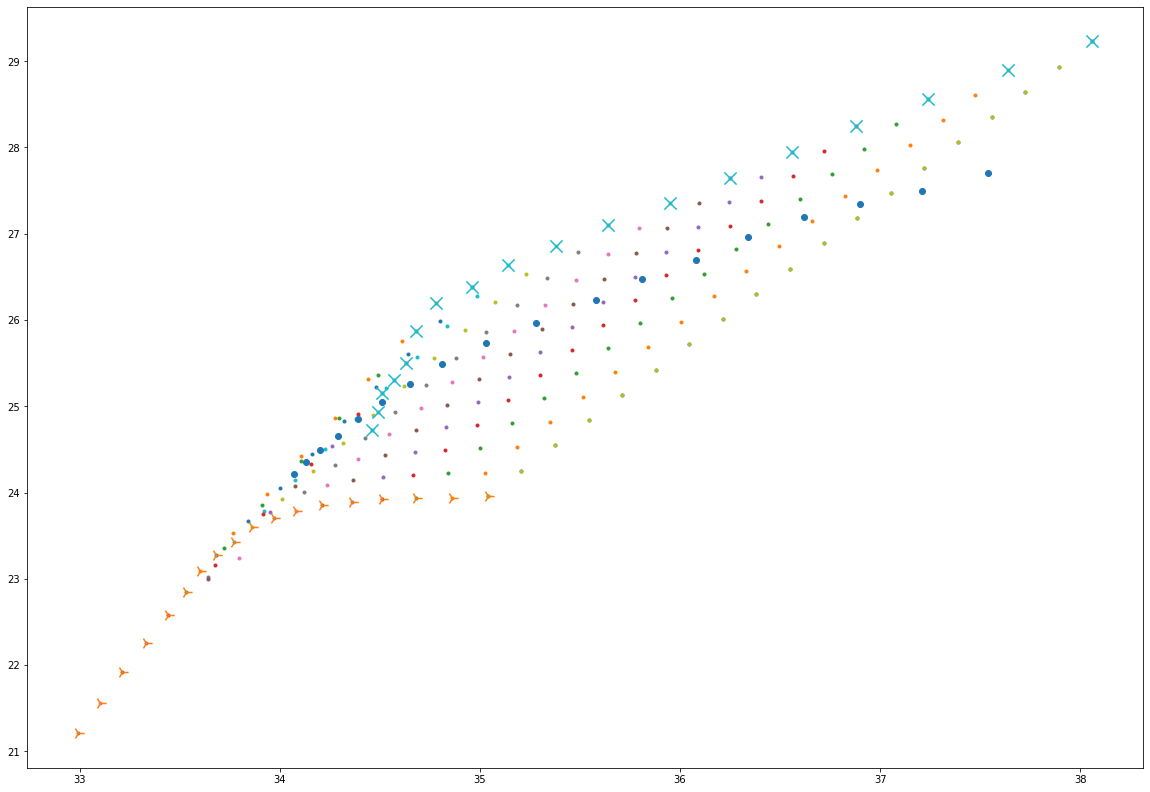

In [180]:
#display(plot_tracking_data)


#only deviation while in the interface zone will contribute to score

track_x = plot_tracking_data['rush_x'].tolist()
track_y = plot_tracking_data['rush_y'].tolist()


#actual euclidean measure
act_meas_x = plot_tracking_data['rush_x'][interface_start+1]
act_meas_y = plot_tracking_data['rush_y'][interface_start+1]


import matplotlib.pyplot as plt
 
plt.rcParams["figure.figsize"] = (20,14)

#data
#original line from 0 rushxy,y to 0 qbx,y
orig_x = coords_list[0][0] #list of x
orig_y = coords_list[0][1] #list of y
for c,i in plot_tracking_data.iterrows():
  plot_x = coords_list[c-interface_start][0] #list of x
  plot_y = coords_list[c-interface_start][1]
  plt.scatter(plot_x, plot_y, marker = '.')

#plot the 2nd predicted line coords_list[1], compare to actual 2nd position tracking_data:rush_x,y[6]
#actual 1 rush_xy compared to the 1 line_x,y prediction
#mark the line1_xy 
x = coords_list[0][0]
y = coords_list[0][1]

#mark the actual rush_x,y
actual_x = plot_tracking_data['rush_x'][interface_start+1] 
actual_y = plot_tracking_data['rush_y'][interface_start+1]

#mark the actual position of blocker
#mark the actual rush_x,y
blocker_x = plot_tracking_data['block_x'] 
blocker_y = plot_tracking_data['block_y']
qb_x = plot_tracking_data['qb_x'] 
qb_y = plot_tracking_data['qb_y']

#marker - triangle up
m = "."
 
#scatter plot
plt.scatter(x, y, marker = m)
plt.scatter(track_x, track_y, marker="x", s=150)
plt.scatter(blocker_x, blocker_y, marker="o")
plt.scatter(qb_x, qb_y, marker="4", s=150)
 
plt.show()

In [ ]:
#momentum measure: the ability of the OT to slow down the DE over the length of the play
#add this to block_metrics, get weekx.a for interface range, the lower the a, the higher the score

# **SQLite Admin Tasks**

In [166]:
#adding/altering/dropping tables

#sql = "DELETE FROM qbi_metrics"
#sql = "DELETE FROM block_metrics"
sql = "DELETE FROM lines_metrics"
#sql = "DROP TABLE '456_2021090900'"
#sql = "SELECT * from sqlite_master"
'''
sql = """CREATE TABLE IF NOT EXISTS "lines_metrics" (
"blocker_id" INT NOT NULL,
"defender_id" INT NOT NULL,
"gameId" INT NOT NULL,
"playId" INT NOT NULL,
    "score"  REAL NOT NULL,
    "total_frames" INT NOT NULL,
    "euclideans" varchar(1000),
    "lines_list" varchar(2500)
    )"""
'''
# blocker_id, defender_id, game_id, play_id, score, total_frames, euclideans, lines_list

cursor = con.cursor()
# Execute the query
cursor.execute(sql)
# the connection is not autocommited by default. So we must commit to save our changes.
con.commit()
